# LUNA Basic Tutorial #3 - Controlling parameters, functions, and filters to calculate interactions

This tutorial will cover: 
* How interactions are defined and which parameters can be modified in LUNA?
* How to turn off specific parameters.
* How to define custom functions to calculate interactions.
* How to define filters for controlling how interactions are calculated.
* How to apply post-filtering functions.

In [1]:
from IPython.display import display, Math

import matplotlib.pyplot as plt
import multiprocessing as mp
import time
import os
import json
import pandas as pd

### Set up system paths and import LUNA

In [2]:
LUNA_path = '/media/data/Workspace/LUNA' # change this to point to LUNA directory

import sys
sys.path.append(LUNA_path)

import luna

/home/alexandrefassio/miniconda3/envs/luna-env/lib/python3.7/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


## Define entries

The definition of entries is covered in Tutorial #1.

Here, we just create the entries that we'll be using throughout this tutorial.

In [3]:
from luna.mol.entry import CompoundEntry, MolEntry, ChainEntry

<MolEntry: D4:ZINC000012442563>
<MolEntry: D4:ZINC000065293174>
<MolEntry: D4:ZINC000096459890>
<MolEntry: D4:ZINC000343043015>
<MolEntry: D4:ZINC000575033470>



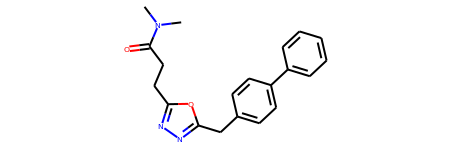

In [4]:
input_file = "./inputs/MolEntries.txt"
entries = list(MolEntry.from_file(input_file, pdb_id="D4", mol_file="./inputs/ligands.mol2", is_multimol_file=True, mol_obj_type="openbabel"))

for e in entries:
    print(e)
print()

entries[0].mol_obj.as_rdkit()

## Running LUNA with default configuration for comparison purposes

The definition of a configuration for running LUNA is covered in Tutorial #1. For simplicity, we won't cover the configuration details again.

### Define default filters and interaction calculators

In [5]:
from luna.mol.interaction.filter import InteractionFilter
from luna.mol.interaction.calc import InteractionCalculator

In [6]:
pli_filter = InteractionFilter.new_pli_filter() # protein-ligand interactions
inter_calc = InteractionCalculator(inter_filter=pli_filter)

### Define default configuration and run LUNA

In [115]:
opt = {}

opt['entries'] = entries # The list of entries to calculate 
opt['working_path'] = "./outputs/luna_results" # Where project results will be saved
opt['pdb_path'] = "./inputs" # Path containing local PDB files or to where the PDB files will be downloaded. PDB filenames must match that defined for the entries.

opt['overwrite_path'] = False # Allows script to overwrite directory - can remove files from previous project.

opt['try_h_addition'] = False  # Define if you need to add Hydrogens or not.
opt['ph'] = 7.4 # Controls the pH and how the hydrogens are going to be added - default 7.4. It doesn't modify the protonation of molecular files defined by a MolEntry object.

# Whether or not to fix atomic charges, valence, and bond types for small molecules and residues at PDB files. 
# Only molecules at PDB files are validated because they don't contain charge, valence, and bond types. That causes molecules to be sometimes incorrectly perceived.
#
# This procedure is only applied for molecules at PDB files. Therefore, molecules from external files (MolEntry objects) won't be modified.
#
opt['amend_mol'] = False

opt['inter_calc'] = inter_calc

opt['mol_obj_type'] = 'rdkit' # What type of mol object, options are 'rdkit' and 'openbabel' - default rdkit
opt['calc_ifp'] = False # Whether or not to calculate interaction fingerprints

opt['nproc'] = None # Define how many processors to use. If you set it to None, LUNA will be run serially.

opt['binding_mode_filter'] = None # Provide a BindingModeFilter object that specifies how to filter binding modes.

opt['logging_enabled'] = True # Enable logger
opt['verbosity'] = 2 # How verbose is the logger

In [116]:
from luna.version import __version__
from luna import LocalProject

if not os.path.exists("%s/project_v%s.pkl.gz" % (opt["working_path"], __version__)):
    proj_obj = luna.projects.LocalProject(**opt)
    proj_obj.run()
else:
    print("Reloading project...")
    print()
    proj_obj = LocalProject.load(opt["working_path"], verbosity=3, logging_enabled=True)

Reloading project...



/media/data/Workspace/LUNA/luna/projects.py:282: UserWarning: Logging mode was set ON. Logging information will be saved from now on.
  warnings.warn("Logging mode was set ON. Logging information will be saved from now on.")


### Evaluate results.

In [13]:
from luna.analysis.summary import count_interaction_types

In [117]:
counts = []
for im in proj_obj.interactions_mngrs:
    count = count_interaction_types(im)
    count["Ligand"] = im.entry.to_string().replace("D4:", "")
    counts.append(count)
    
counts_df = pd.DataFrame.from_dict(counts).fillna(0)
counts_df = counts_df[ ['Ligand'] + [ col for col in counts_df.columns if col != 'Ligand' ] ]
counts_df

,Ligand,Hydrophobic,Double bond,Van der Waals,Face-to-edge pi-stacking,Single bond,Weak hydrogen bond,Tilted multipolar,Cation-pi,Displaced face-to-edge pi-stacking,Cation-nucleophile,Van der Waals clash,Ionic,Halogen bond,Unfavorable cation-electrophile,Hydrogen bond,Chalcogen bond
0,ZINC000012442563,8,9,12,1.0,18,8,1.0,1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ZINC000065293174,8,6,4,1.0,20,7,0.0,1,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0
2,ZINC000096459890,10,9,5,0.0,17,1,0.0,1,3.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,ZINC000343043015,6,6,3,1.0,16,8,0.0,1,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0
4,ZINC000575033470,8,6,24,0.0,19,6,1.0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# How interactions are defined and which parameters can be modified in LUNA?

### Interaction Configuration
This is the set of rules that define the distances and angles used to define the different types of interactions. The default configuration can be found in luna/mol/interaction/calc.py. This can be modified to support different interaction definitions.

In [15]:
from luna.mol.interaction.conf import DefaultInteractionConf

When creating an InteractionCalculator object, the default configuration for interactions is used, as can be seen below:
    
  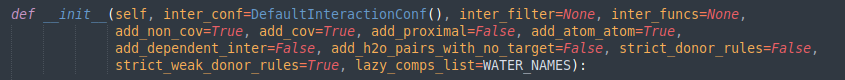  

The configuration for interactions is defined as dictionaries and can be accessed through the property **conf**.

In [57]:
inter_conf = DefaultInteractionConf()
print(inter_conf.conf["max_da_dist_hb_inter"])

3.9


Since it is a dictionary, you can modify the default parameters as shown below.

In [58]:
inter_conf.conf["max_da_dist_hb_inter"] = 4.0
print(inter_conf.conf["max_da_dist_hb_inter"])

4.0


The full set of interactions and their default values are described in detail below:

### Hydrogen bond.

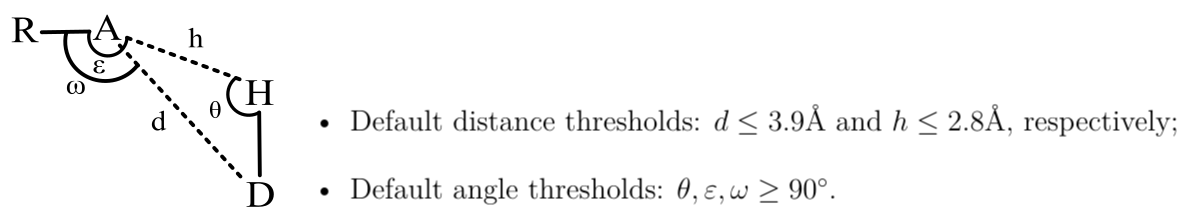

**D, H, A, and R are the donor, hydrogen, a Lewis base (acceptor), and an atom covalently bound to the acceptor, respectively.**

**The parameters that control this type of interaction are shown below:**

In [142]:
inter_conf = DefaultInteractionConf()

display(Math(r'$d = | \overline{DA} | \leq %.1f\ \mathring A$' % inter_conf.conf["max_da_dist_hb_inter"]))
display(Math(r'$h = | \overline{HA} | \leq %.1f\ \mathring A$' % inter_conf.conf["max_ha_dist_hb_inter"]))

display(Math(r'\theta = D\hat{H}A \geq %d^{\circ}' % inter_conf.conf["min_dha_ang_hb_inter"]))
display(Math(r'\epsilon = H\hat{A}R \geq %d^{\circ}' % inter_conf.conf["min_har_ang_hb_inter"]))
display(Math(r'\omega = D\hat{A}R \geq %d^{\circ}' % inter_conf.conf["min_dar_ang_hb_inter"]))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Weak hydrogen bond.

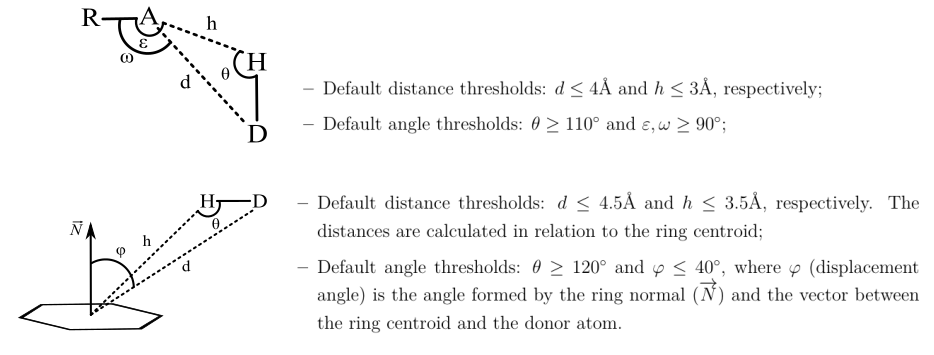

**In the first model, D, H, A, and R are a weak hydrogen donor (Carbon), hydrogen, an acceptor or weak acceptor (aromatic Oxygen/Sulfur, Fluorine), and an atom covalently bound to the [weak] acceptor, respectively.**

**The parameters that control this type of interaction are shown below:**

In [144]:
inter_conf = DefaultInteractionConf()

display(Math(r'$d = | \overline{DA} | \leq %.1f\ \mathring A$' % inter_conf.conf["max_da_dist_whb_inter"]))
display(Math(r'$h = | \overline{HA} | \leq %.1f\ \mathring A$' % inter_conf.conf["max_ha_dist_whb_inter"]))

display(Math(r'\theta = D\hat{H}A \geq %d^{\circ}' % inter_conf.conf["min_dha_ang_whb_inter"]))
display(Math(r'\epsilon = H\hat{A}R \geq %d^{\circ}' % inter_conf.conf["min_har_ang_whb_inter"]))
display(Math(r'\omega = D\hat{A}R \geq %d^{\circ}' % inter_conf.conf["min_dar_ang_whb_inter"]))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**In the second model, the acceptor atom is substitued by an aromatic ring, whose centroid is defined as $c$.**

**The parameters that control this type of interaction are shown below:**

In [147]:
inter_conf = DefaultInteractionConf()

display(Math(r'$d = | \overline{Dc} | \leq %.1f\ \mathring A$' % inter_conf.conf["max_dc_dist_whb_inter"]))
display(Math(r'$h = | \overline{Hc} | \leq %.1f\ \mathring A$' % inter_conf.conf["max_hc_dist_whb_inter"]))

display(Math(r'\theta = D\hat{H}c \geq %d^{\circ}' % inter_conf.conf["min_dhc_ang_whb_inter"]))
display(Math(r'\varphi = \langle \vec{N}, \vec{cD} \rangle \leq %d^{\circ}' % inter_conf.conf["max_disp_ang_whb_inter"]))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Halogen bond.

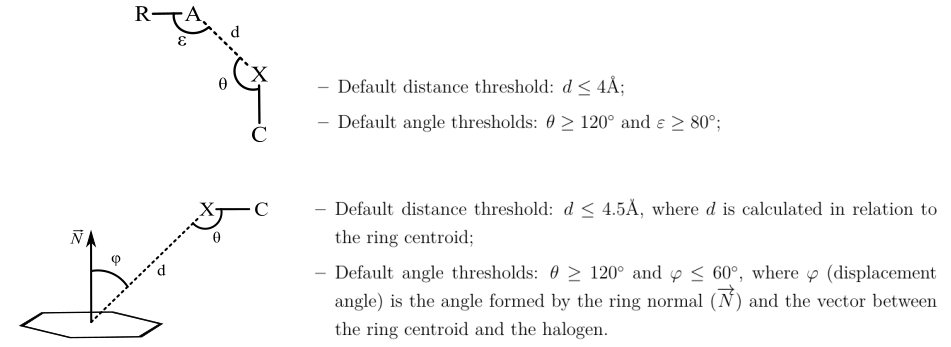

**In the first model, X, C, A, R are a halogen, a carbon bound to the halogen, a Lewis base (acceptor), and an atom covalently bound to the acceptor, respectively.**

**The parameters that control this type of interaction are shown below:**

In [151]:
inter_conf = DefaultInteractionConf()

display(Math(r'$d = | \overline{XA} | \leq %.1f\ \mathring A$' % inter_conf.conf["max_xa_dist_xbond_inter"]))

display(Math(r'\theta = C\hat{X}A \geq %d^{\circ}' % inter_conf.conf["min_cxa_ang_xbond_inter"]))
display(Math(r'\epsilon = X\hat{A}R \geq %d^{\circ}' % inter_conf.conf["min_xar_ang_xbond_inter"]))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**In the second model, the acceptor atom is substitued by an aromatic ring, whose centroid is defined as $c$.**

**The parameters that control this type of interaction are shown below:**

In [174]:
inter_conf = DefaultInteractionConf()

display(Math(r'$d = | \overline{Xc} | \leq %.1f\ \mathring A$' % inter_conf.conf["max_xc_dist_xbond_inter"]))

display(Math(r'\theta = C\hat{X}c \geq %d^{\circ}' % inter_conf.conf["min_cxa_ang_xbond_inter"]))
display(Math(r'\varphi = \langle \vec{N}, \vec{cX} \rangle \leq %d^{\circ}' % inter_conf.conf["max_disp_ang_xbond_inter"]))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Chalcogen bond.

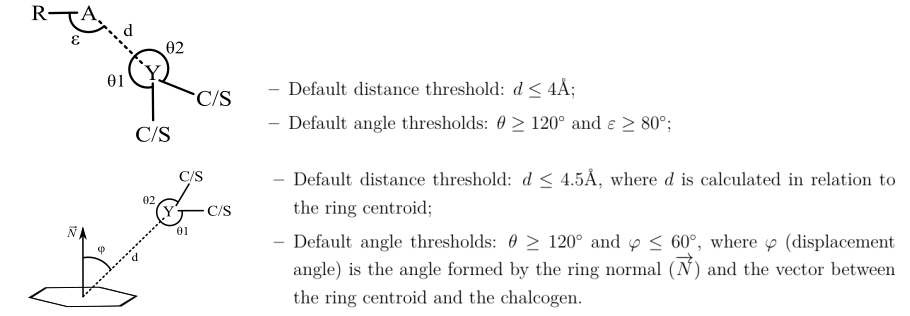

**In the first model, Y , C/S, B, R are a chalcogen, a carbon/sulfur bound to the chalcogen, a Lewis base (acceptor), and an atom covalently bound to the acceptor, respectively.**

**The parameters that control this type of interaction are shown below:**

In [170]:
inter_conf = DefaultInteractionConf()

display(Math(r'$d = | \overline{YA} | \leq %.1f\ \mathring A$' % inter_conf.conf["max_ya_dist_ybond_inter"]))

display(Math(r'\theta = {YC\hat}A \geq %d^{\circ}' % inter_conf.conf["min_rya_ang_ybond_inter"]))
display(Math(r'\epsilon = Y\hat{A}R \geq %d^{\circ}' % inter_conf.conf["min_yan_ang_ybond_inter"]))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**In the second model, the acceptor atom is substitued by an aromatic ring, whose centroid is defined as $c$.**

**The parameters that control this type of interaction are shown below:**

In [175]:
inter_conf = DefaultInteractionConf()

display(Math(r'$d = | \overline{Yc} | \leq %.1f\ \mathring A$' % inter_conf.conf["max_yc_dist_ybond_inter"]))

display(Math(r'\theta = C\hat{Y}c \geq %d^{\circ}' % inter_conf.conf["min_rya_ang_ybond_inter"]))
display(Math(r'\varphi = \langle \vec{N}, \vec{cY} \rangle \leq %d^{\circ}' % inter_conf.conf["max_disp_ang_ybond_inter"]))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Aromatic stacking

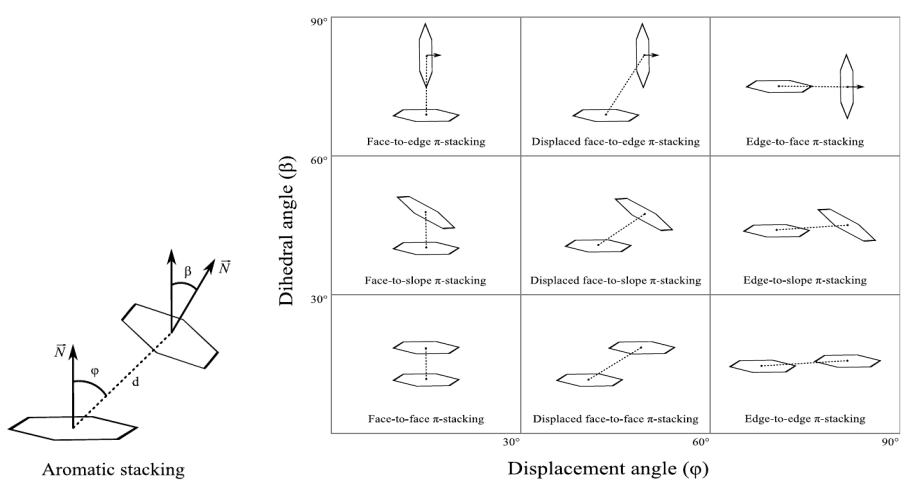

* **Default distance threshold: d ≤ 6Å, where d is calculated in relation to the ring centroids;**

* **Default angle thresholds: each specific stacking depends on a combination of φ and β angles, as shown above, where φ (displacement angle) is the angle formed by the ring normal ( $\vec{N}$ ) and the vector between the two ring centroids; while β (dihedral angle) is the angle between the two ring planes, which is calculated by the angle formed by the ring normals. The displacement angle is calculated using both rings as references, and the smallest angle is chosen for defining the stacking type.**

**The parameters that control this type of interaction are shown below:**

In [18]:
inter_conf = DefaultInteractionConf()

display(Math(r'$d = | \overline{c_{r1}c_{r2}} | \leq %.1f\ \mathring A$' % inter_conf.conf["max_cc_dist_pi_pi_inter"]))

display(Math(r'\beta_{min} = \langle \vec{N_{r1}}, \vec{N_{r2}} \rangle_{min} = %d^{\circ}' % inter_conf.conf["min_dihed_ang_slope_pi_pi_inter"]))
display(Math(r'\beta_{max} = \langle \vec{N_{r1}}, \vec{N_{r2}} \rangle_{max} = %d^{\circ}' % inter_conf.conf["max_dihed_ang_slope_pi_pi_inter"]))


display(Math(r'\varphi_{min} = \langle \vec{N_{r1}}, \vec{c_{r1}c_{r2}} \rangle_{min} = %d^{\circ}' % inter_conf.conf["min_disp_ang_offset_pi_pi_inter"]))
display(Math(r'\varphi_{max} = \langle \vec{N_{r1}}, \vec{c_{r1}c_{r2}} \rangle_{max} = %d^{\circ}' % inter_conf.conf["max_disp_ang_offset_pi_pi_inter"]))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**Where $c$, $r1$, and $r2$ stand for an aromatic ring centroid, and the bottom and top aromatic rings, respectively.**

### Amide-π stacking

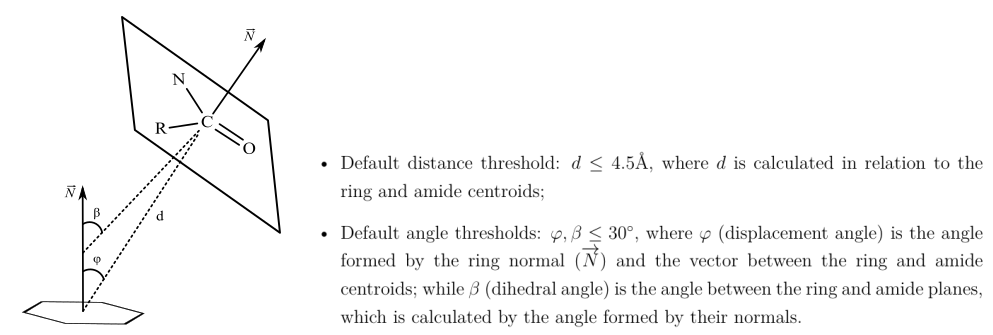

**The parameters that control this type of interaction are shown below:**

In [22]:
inter_conf = DefaultInteractionConf()

display(Math(r'$d = | \overline{c_{am}c_{r}} | \leq %.1f\ \mathring A$' % inter_conf.conf["max_cc_dist_amide_pi_inter"]))

display(Math(r'\beta = \langle \vec{N_{r}}, \vec{N_{am}} \rangle \leq %d^{\circ}' % inter_conf.conf["max_dihed_ang_amide_pi_inter"]))

display(Math(r'\varphi = \langle \vec{N_{r}}, \vec{c_{r}c_{am}} \rangle \leq %d^{\circ}' % inter_conf.conf["max_disp_ang_pi_pi_inter"]))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**Where $r$ and $am$ stand for the aromatic ring and amide.**

### Dipole-dipole or multipolar interactions

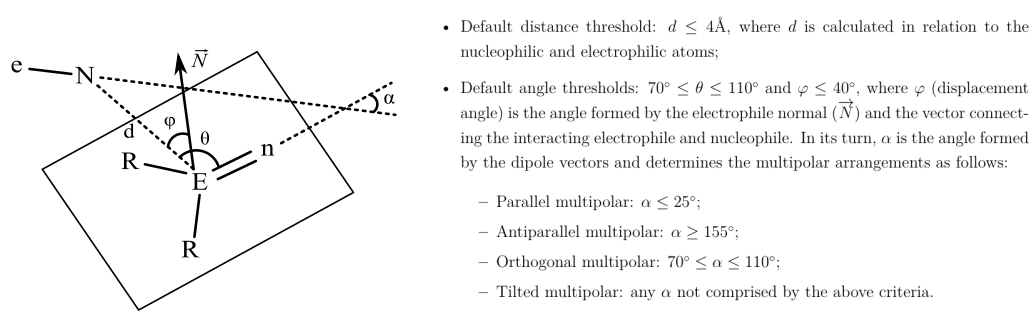

$$\require{mhchem}$$

**Where $\ce{E\bond{=}n}$ and $\ce{N \sbond e}$ are the dipoles containing the interacting electrophile (E) and nucleophile (N); and R are the atoms covalently bound to the electrophile.**

**There are four possible arrangements for favorable multipolar interactions:**
* Parallel multipolar;
* Antiparallel multipolar;
* Orthogonal multipolar;
* Tilted multipolar.

The algorithm also detects **unfavorable dipole-dipole interactions**, which are classified either as **unfavorable nucleophile-nucleophile** or **unfavorable electrophile-electrophile**. However, the arrangements presented above are not employed for unfavorable interactions and, therefore, the tool only evaluates the distance d and angles θ and φ in the same way presented for the favorable interactions.

**The parameters that control this type of interaction are shown below:**

In [50]:
inter_conf = DefaultInteractionConf()

display(Math(r'$d = | \overline{NE} | \leq %.1f\ \mathring A$' % inter_conf.conf["max_ne_dist_multipolar_inter"]))

display(Math(r'%d^{\circ} \leq \theta = N\hat{E}n \leq %d^{\circ}' % (inter_conf.conf["min_ney_ang_multipolar_inter"], inter_conf.conf["max_ney_ang_multipolar_inter"])))

display(Math(r'\varphi = \langle \vec{N_{e}}, \vec{EN} \rangle \leq %d^{\circ}' % inter_conf.conf["max_disp_ang_multipolar_inter"]))

display(Math(r'\ \ \ \bullet Parallel\ multipolar: \alpha = \langle \vec{En}, \vec{eN} \rangle \leq %d^{\circ}' % inter_conf.conf["max_an_ey_ang_para_multipolar_inter"]))

display(Math(r'\ \ \ \bullet Orthogonal\ multipolar: %d^{\circ} \leq \alpha = \langle \vec{En}, \vec{eN} \rangle \leq %d^{\circ}' % (inter_conf.conf["min_an_ey_ang_ortho_multipolar_inter"], inter_conf.conf["max_an_ey_ang_ortho_multipolar_inter"])))

display(Math(r'\ \ \ \bullet Antiparallel\ multipolar: \alpha = \langle \vec{En}, \vec{eN} \rangle \geq %d^{\circ}' % inter_conf.conf["min_an_ey_ang_antipara_multipolar_inter"]))

display(Math(r'\ \ \ \bullet Tilted\ multipolar:\ any\ \alpha\ not\ comprised\ by\ the\ above\ criteria.'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Ion-dipole interaction

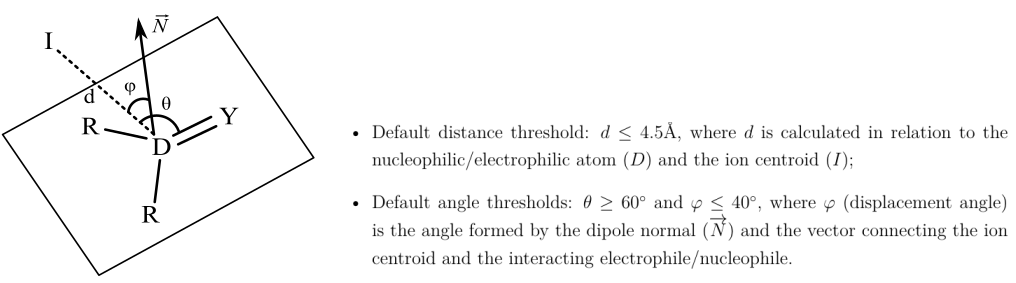

$$\require{mhchem}$$

**Where I is the ion centroid and $\ce{D\bond{=}Y}$ is the dipole, having D as the electrophile when Y is the nucleophile and vice versa.**

**There are two favorable interactions:**
* Cation-nucleophile;
* Anion-electrophile.

**And there are two unfavorable interactions:**
* Unfavorable anion-nucleophile;
* Unfavorable cation-electrophile.

**The parameters that control this type of interaction are shown below:**

In [53]:
inter_conf = DefaultInteractionConf()

display(Math(r'$d = | \overline{ID} | \leq %.1f\ \mathring A$' % inter_conf.conf["max_id_dist_ion_multipole_inter"]))

display(Math(r'\theta = \langle \vec{DI}, \vec{DY} \rangle \geq %d^{\circ}' % inter_conf.conf["min_idy_ang_ion_multipole_inter"]))

display(Math(r'\varphi = \langle \vec{N}, \vec{DI} \rangle \leq %d^{\circ}' % inter_conf.conf["max_disp_ang_ion_multipole_inter"]))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Ionic and repulsive interactions

**The parameters that control this type of interaction are shown below:**

In [64]:
inter_conf = DefaultInteractionConf()

display(Math(r'$Ionic: d = | \overline{I_{1}I_{2}} | \leq %.1f\ \mathring A$' % inter_conf.conf["max_dist_attract_inter"]))
display(Math(r'$Repulsive: d = | \overline{I_{1}I_{2}} | \leq %.1f\ \mathring A$' % inter_conf.conf["max_dist_repuls_inter"]))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Cation-π interaction

**The parameters that control this type of interaction are shown below:**

In [65]:
inter_conf = DefaultInteractionConf()

display(Math(r'$d = | \overline{Ic_{r}} | \leq %.1f\ \mathring A$' % inter_conf.conf["max_dist_cation_pi_inter"]))

<IPython.core.display.Math object>

### Hydrophobic

Hydrophobic interactions can be modeled as **atom-atom interactions** or as **surface-surface contacts**, which is the default approach in our tool. The former is identified when any two hydrophobic atoms are up to 4.5 Å apart.

**Surface-surface contacts**, are identified as follows. Firstly, the tool computes hydrophobic interactions between atoms as explained for the atom-atom
model. Then, it identifies all hydrophobic atoms covalently bound to each other and merges them to form a hydrophobic cluster/island, called hydrophobe. Finally, the tool converts each atom-atom interaction to its hydrophobe-hydrophobe form by identifying the hydrophobic clusters comprehending each interacting atom and attributing this interaction to them. However, it may be possible that not all hydrophobic atoms in a cluster participate in the surface-surface contact. For that reason, each interaction contains the hydrophobic cluster information as a whole and keeps track of which of their specific atoms are in contact.

**The parameters that control this type of interaction are shown below:**

In [82]:
inter_conf = DefaultInteractionConf()

display(Math(r'$d = | \overline{Hpho_{1}Hpho_{2}} | \leq %.1f\ \mathring A$' % inter_conf.conf["max_dist_hydrop_inter"]))

display(Math(r'$Surface\ size \geq %.1f$' % inter_conf.conf["min_surf_size"]))

display(Math(r'$\#\ interacting\ atoms\ in\ the\ surface \geq %.1f$' % inter_conf.conf["min_inter_atom_in_surf"]))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Covalent bond


Covalent bonds are automatically obtained from Open Babel or RDKit. However, when the precomputed set of properties for atoms are used during the physicochemical
feature assignment, it is necessary to manually compute covalent bonds as these intermediary tools are not used. To do so, we implemented the Open Babel model for covalent bonds detection, whose expression is defined below:
</br>
</br>


<center>$0.4 \le d \le A_{cov} + B_{cov} + 0.45$</center>

</br>

Where $d$ is the Euclidean distance between two atoms $A$ and $B$, while $A_{cov}$ and $B_{cov}$ are their covalent radii, which are derived from Open Babel.


### Atom overlap

Atom overlap identifies artifacts generated by low-resolution structures and homology models, which consists of unnatural overlap of two atoms. An overlap is defined
as two atoms not covalently bound separated from each other by less than or equal to the sum of their covalent radii.

### Van der Waals clash

Van der Waals clashes are identified by the following expression:
</br>

<center> $A_{vdw} + B_{vdw} - d \ge 0.6$ </center>
    
</br>
    
Where $d$ is the Euclidean distance between two atoms $A$ and $B$, $A_{vdw}$ and $B_{vdw}$ are their van der Waals radii, and 0.6 is the threshold for van der Waals clashes. Van der Waals radii are derived from Open Babel.

**The parameters that control this type of interaction are shown below:**

In [89]:
inter_conf = DefaultInteractionConf()

display(Math(r'$van\ der\ Waals\ clash\ tolerance = %.1f\ \mathring A$' % inter_conf.conf["vdw_clash_tolerance"]))

<IPython.core.display.Math object>

### Van der Waals interaction

Van der Waals interactions are identified by the following expression:
</br>

<center> $d \le A_{vdw} + B_{vdw} + 0.1$ </center>
</br>

Where $d$ is the Euclidean distance between two atoms $A$ and $B$, $A_{vdw}$ and $B_{vdw}$ are their van der Waals radii, and 0.1 is a margin of error. Van der Waals radii are derived from Open Babel.

**The parameters that control this type of interaction are shown below:**

In [90]:
inter_conf = DefaultInteractionConf()

display(Math(r'$van\ der\ Waals\ tolerance = %.1f\ \mathring A$' % inter_conf.conf["vdw_tolerance"]))

<IPython.core.display.Math object>

### Proximal interactions

Proximal interactions are defined as any two atoms separated from each other by at least 2Å and at most 6Å.

**The parameters that control this type of interaction are shown below:**

In [92]:
inter_conf = DefaultInteractionConf()

display(Math(r'$%.1f\ \mathring A \leq d = | \overline{A_{1}A_{2}} | \leq %.1f\ \mathring A$' % (inter_conf.conf["min_dist_proximal"], inter_conf.conf["max_dist_proximal"])))

<IPython.core.display.Math object>

# How to turn off specific parameters

In LUNA, if you don't want to define custom functions, you can turn off specific parameters to make the function less restrictive.

Let's take as an example the Hydrogen bonds.

As previously described, hydrogen bonds are defined by 5 parameters:

In [142]:
inter_conf = DefaultInteractionConf()

display(Math(r'$d = | \overline{DA} | \leq %.1f\ \mathring A$' % inter_conf.conf["max_da_dist_hb_inter"]))
display(Math(r'$h = | \overline{HA} | \leq %.1f\ \mathring A$' % inter_conf.conf["max_ha_dist_hb_inter"]))

display(Math(r'\theta = D\hat{H}A \geq %d^{\circ}' % inter_conf.conf["min_dha_ang_hb_inter"]))
display(Math(r'\epsilon = H\hat{A}R \geq %d^{\circ}' % inter_conf.conf["min_har_ang_hb_inter"]))
display(Math(r'\omega = D\hat{A}R \geq %d^{\circ}' % inter_conf.conf["min_dar_ang_hb_inter"]))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Let's say we don't want the angle thresholds. Do the following:

In [132]:
custom_inter_conf = DefaultInteractionConf()

del custom_inter_conf.conf["min_dha_ang_hb_inter"]
del custom_inter_conf.conf["min_har_ang_hb_inter"]
del custom_inter_conf.conf["min_dar_ang_hb_inter"]

Let's remove angles from weak hydrogen bonds as well:

In [133]:
del custom_inter_conf.conf["min_dha_ang_whb_inter"]
del custom_inter_conf.conf["min_har_ang_whb_inter"]
del custom_inter_conf.conf["min_dar_ang_whb_inter"]

Now, just define a new InteractionCalculator object.

In [134]:
pli_filter = InteractionFilter.new_pli_filter() # protein-ligand interactions

inter_calc = InteractionCalculator(inter_conf=custom_inter_conf, inter_filter=pli_filter)

working_path = "./outputs/custom_inter_calc_results"

Define a new configuration object.

In [136]:
opt = {}

opt['entries'] = entries # The list of entries to calculate 
opt['working_path'] = working_path # Where project results will be saved
opt['pdb_path'] = "./inputs" # Path containing local PDB files or to where the PDB files will be downloaded. PDB filenames must match that defined for the entries.

opt['overwrite_path'] = False # Allows script to overwrite directory - can remove files from previous project.

opt['try_h_addition'] = False  # Define if you need to add Hydrogens or not.
opt['ph'] = 7.4 # Controls the pH and how the hydrogens are going to be added - default 7.4. It doesn't modify the protonation of molecular files defined by a MolEntry object.

# Whether or not to fix atomic charges, valence, and bond types for small molecules and residues at PDB files. 
# Only molecules at PDB files are validated because they don't contain charge, valence, and bond types. That causes molecules to be sometimes incorrectly perceived.
#
# This procedure is only applied for molecules at PDB files. Therefore, molecules from external files (MolEntry objects) won't be modified.
#
opt['amend_mol'] = False

opt['inter_calc'] = inter_calc

opt['mol_obj_type'] = 'rdkit' # What type of mol object, options are 'rdkit' and 'openbabel' - default rdkit
opt['calc_ifp'] = False # Whether or not to calculate interaction fingerprints

opt['nproc'] = None # Define how many processors to use. If you set it to None, LUNA will be run serially.

opt['binding_mode_filter'] = None # Provide a BindingModeFilter object that specifies how to filter binding modes.

opt['logging_enabled'] = True # Enable logger
opt['verbosity'] = 2 # How verbose is the logger

Run LUNA or reload an existing project.

In [137]:
from luna.version import __version__
from luna import LocalProject

if not os.path.exists("%s/project_v%s.pkl.gz" % (opt["working_path"], __version__)):
    proj_obj = luna.projects.LocalProject(**opt)
    proj_obj.run()
else:
    print("Reloading project...")
    print()
    proj_obj = LocalProject.load(opt["working_path"], verbosity=3, logging_enabled=True)

/media/data/Workspace/LUNA/luna/projects.py:282: UserWarning: Logging mode was set ON. Logging information will be saved from now on.
  warnings.warn("Logging mode was set ON. Logging information will be saved from now on.")
[2021-10-18 11:19:10]    WARNING         projects.py:320        The number of processes was set to 'None'. Therefore, LUNA will run jobs sequentially.


[2021-10-18 11:19:46]    PROGRESS                               100% [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■] 5/5 [Avg: 7.21s/task; Errors: 0] - Entries processing.


### Compare the difference between the default and custom project.

In [138]:
counts = []
for im in proj_obj.interactions_mngrs:
    count = count_interaction_types(im)
    count["Ligand"] = im.entry.to_string().replace("D4:", "")
    counts.append(count)
    
custom_counts_df = pd.DataFrame.from_dict(counts).fillna(0)
custom_counts_df = custom_counts_df[ ['Ligand'] + [ col for col in custom_counts_df.columns if col != 'Ligand' and col in ["Hydrogen bond", "Weak hydrogen bond"]]]
custom_counts_df

,Ligand,Weak hydrogen bond,Hydrogen bond
0,ZINC000012442563,9,0.0
1,ZINC000065293174,8,0.0
2,ZINC000096459890,2,0.0
3,ZINC000343043015,8,2.0
4,ZINC000575033470,8,1.0


Difference between the custom and the default versions.

In [139]:
custom_counts_df[["Weak hydrogen bond", "Hydrogen bond"]] - counts_df[["Weak hydrogen bond", "Hydrogen bond"]]

,Weak hydrogen bond,Hydrogen bond
0,1,0.0
1,1,0.0
2,1,0.0
3,0,0.0
4,2,1.0


## How to define custom functions to calculate interactions.

Functions to calculate interactions are defined through the parameter "inter_funcs" during the initialization of a new InteractionCalculator object.

This parameter accepts a dictionary where keys are pairs of atom types and whose values are a list of functions in case multiple interactions are perceived for that pair of atoms. For instance:


<code> { 
        ("Hydrophobic", "Hydrophobic"): [ my_custom_function(), the_collest_function() ]
 } </code>

By default, inter_funcs is set with the default functions to calculate each type of interaction. You can access the dictionary through the property "funcs" as shown below:

In [143]:
pli_filter = InteractionFilter.new_pli_filter() # protein-ligand interactions

inter_calc = InteractionCalculator(inter_filter=pli_filter)

inter_calc.funcs

{('Hydrophobic',
  'Hydrophobic'): [<function luna.mol.interaction.calc.InteractionCalculator.calc_hydrop(self, params)>],
 ('Hydrophobe',
  'Hydrophobe'): [<function luna.mol.interaction.calc.InteractionCalculator.calc_hydrop(self, params)>],
 ('Donor',
  'Acceptor'): [<function luna.mol.interaction.calc.InteractionCalculator.calc_hbond(self, params)>],
 ('WeakDonor',
  'Acceptor'): [<function luna.mol.interaction.calc.InteractionCalculator.calc_weak_hbond(self, params)>],
 ('WeakDonor',
  'WeakAcceptor'): [<function luna.mol.interaction.calc.InteractionCalculator.calc_weak_hbond(self, params)>],
 ('Donor',
  'Aromatic'): [<function luna.mol.interaction.calc.InteractionCalculator.calc_hbond_pi(self, params)>],
 ('WeakDonor',
  'Aromatic'): [<function luna.mol.interaction.calc.InteractionCalculator.calc_hbond_pi(self, params)>],
 ('HalogenDonor',
  'Acceptor'): [<function luna.mol.interaction.calc.InteractionCalculator.calc_xbond(self, params)>],
 ('HalogenDonor',
  'Aromatic'): [<func

**If for some reason, you decide to define your custom functions, you can:**
    
    1. Overwrite the default dictionary after creating the InteractionCalculator object;
    2. Provide a new dictionary during the creation of the InteractionCalculator object.

### Overwrite the default dictionary.

In [153]:
import luna.mol.interaction.math as lmath
from luna.mol.interaction.type import InteractionType

def custom_hbond_function(self, params):
    if not self.add_non_cov:
        return []

    group1, group2, feat1, feat2 = params
    interactions = []

    cc_dist = lmath.euclidean_distance(group1.centroid, group2.centroid)
    if cc_dist <= 4:
        params = {"dist_hbond_inter": cc_dist}
        inter = InteractionType(group1, group2, "Hydrogen bond", params=params)

        interactions.append(inter)
    return interactions


working_path = "./outputs/custom_function_results"

pli_filter = InteractionFilter.new_pli_filter() # protein-ligand interactions

inter_calc = InteractionCalculator(inter_filter=pli_filter)

inter_calc.funcs[("Donor", "Acceptor")] = [custom_hbond_function]

inter_calc.funcs[("Donor", "Acceptor")]

[<function __main__.custom_hbond_function(self, params)>]

Define a new configuration object.

In [154]:
opt = {}

opt['entries'] = entries # The list of entries to calculate 
opt['working_path'] = working_path # Where project results will be saved
opt['pdb_path'] = "./inputs" # Path containing local PDB files or to where the PDB files will be downloaded. PDB filenames must match that defined for the entries.

opt['overwrite_path'] = False # Allows script to overwrite directory - can remove files from previous project.

opt['try_h_addition'] = False  # Define if you need to add Hydrogens or not.
opt['ph'] = 7.4 # Controls the pH and how the hydrogens are going to be added - default 7.4. It doesn't modify the protonation of molecular files defined by a MolEntry object.

# Whether or not to fix atomic charges, valence, and bond types for small molecules and residues at PDB files. 
# Only molecules at PDB files are validated because they don't contain charge, valence, and bond types. That causes molecules to be sometimes incorrectly perceived.
#
# This procedure is only applied for molecules at PDB files. Therefore, molecules from external files (MolEntry objects) won't be modified.
#
opt['amend_mol'] = False

opt['inter_calc'] = inter_calc

opt['mol_obj_type'] = 'rdkit' # What type of mol object, options are 'rdkit' and 'openbabel' - default rdkit
opt['calc_ifp'] = False # Whether or not to calculate interaction fingerprints

opt['nproc'] = None # Define how many processors to use. If you set it to None, LUNA will be run serially.

opt['binding_mode_filter'] = None # Provide a BindingModeFilter object that specifies how to filter binding modes.

opt['logging_enabled'] = True # Enable logger
opt['verbosity'] = 2 # How verbose is the logger

Run LUNA or reload an existing project.

In [155]:
from luna.version import __version__
from luna import LocalProject

if not os.path.exists("%s/project_v%s.pkl.gz" % (opt["working_path"], __version__)):
    proj_obj = luna.projects.LocalProject(**opt)
    proj_obj.run()
else:
    print("Reloading project...")
    print()
    proj_obj = LocalProject.load(opt["working_path"], verbosity=3, logging_enabled=True)

/media/data/Workspace/LUNA/luna/projects.py:282: UserWarning: Logging mode was set ON. Logging information will be saved from now on.
  warnings.warn("Logging mode was set ON. Logging information will be saved from now on.")
[2021-10-18 13:33:52]    WARNING         projects.py:320        The number of processes was set to 'None'. Therefore, LUNA will run jobs sequentially.


[2021-10-18 13:34:30]    PROGRESS                               100% [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■] 5/5 [Avg: 7.56s/task; Errors: 0] - Entries processing.


### Compare the difference between the default and custom project.

In [157]:
counts = []
for im in proj_obj.interactions_mngrs:
    count = count_interaction_types(im)
    count["Ligand"] = im.entry.to_string().replace("D4:", "")
    counts.append(count)
    
custom_counts_df = pd.DataFrame.from_dict(counts).fillna(0)
custom_counts_df = custom_counts_df[ ['Ligand'] + [ col for col in custom_counts_df.columns if col != 'Ligand' and col in ["Hydrogen bond"]]]
custom_counts_df

,Ligand,Hydrogen bond
0,ZINC000012442563,0.0
1,ZINC000065293174,2.0
2,ZINC000096459890,1.0
3,ZINC000343043015,2.0
4,ZINC000575033470,4.0


Difference between the custom and the default versions.

In [158]:
custom_counts_df[["Hydrogen bond"]] - counts_df[["Hydrogen bond"]]

,Hydrogen bond
0,0.0
1,2.0
2,1.0
3,0.0
4,4.0
